<a href="https://colab.research.google.com/github/Juanreyna3/Dimensionality-Reduction-with-Autoencoder/blob/main/Dimensionality%20Reduction%20with%20Autoencoder%20/%20Dimensionality_Reduction_by_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality Reduction using an Autoencoder in Python 

[**Part 1**](#task1): Package Importing

[**Part 2**](#task2): Dataset Creation and Preprocessing

[**Part 3**](#task3): Create a Baseline Model with Prinicple Components Analysis (PCA) 

[**Part 4**](#task4): Autoencoder Training

[**Part 5**](#task5): Reducing Dimensionality with AE

- reduces dimensionality from 50 to 2


<a id='part1'></a>
# Part 1: Importing and Introduction

In [15]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

In [16]:
# for making datasets and importing preprocessing techniques
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# importing autoencoder and PCA code
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, silhouette_score

In [17]:
# list of colors for data visualization 
cols = ['#1FC17B', '#78FECF', '#555B6E', '#CC998D', '#429EA6',
        '#153B50', '#8367C7', '#EE6352', '#C287E8', '#F0A6CA', 
        '#521945', '#361F27', '#828489', '#9AD2CB', '#EBD494', 
        '#53599A', '#80DED9', '#EF2D56', '#446DF6', '#AF929D']

<a id='part2'></a>
# Part 2: Dataset Creation and Preprocessing



In [18]:
# makes distributions of data based on given parameters
X, y = make_blobs(n_features=50, centers=20, n_samples=20000, cluster_std=0.2, 
                  random_state=17, center_box=[-1, 1])

Created 50-dimensional data that exists in 20 different clusters

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=17)

# scale each feature to be a value between 0 and 1 (not scaling y data bc they are labels and don't change)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Preprocessed data so each dimension in the 50-dimensional vectors are normalized to fit between 0 and 1.

- preprocessing was done to training data 
- the transformation was applied to the testing data

This is done to make sure you don't bias your training data by your test data and create results that don't reflect was is truly occurring.

<a id='part3'></a>
# Part 3: Baseline Model

We want to try to preserve some of the clustering that is inherently in the data

Text(0.5, 1.0, 'PCA Results')

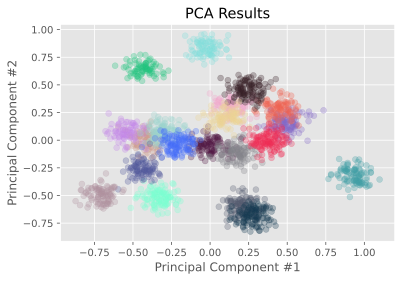

In [20]:
pca = PCA(n_components=2)
pca.fit(X_train)          # fit training data onto the PCA model 

res_pca = pca.transform(X_test)   # get results of transforming test data

unique_labels = np.unique(y_test) # find unique labels of test data for scatterplot

# loop over each cluster to plot data
for index, unique_label in enumerate(unique_labels):  # enumerate() brings back a count
    X_data = res_pca[y_test==unique_label]
    plt.scatter(X_data[:,0], X_data[:,1], alpha=0.3, c=cols[index])
    
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')
plt.title('PCA Results')

<a id='part4'></a>
# Part 4: Autoencoder Theory and Training
![image](Images/ae_viz.pdf)

Multi-layer Preceptron 

Perceptron : weighted sum in a nonlinearity

Since our input is real-valued the task is like a regression task bc we want to predict effecto values

Mirrored models are common for autoencoders (encoder and decoder are mirrored)

In [21]:
# define autoencoder
autoencoder = MLPRegressor(alpha=1e-15, 
                           hidden_layer_sizes=(50, 100, 50, 2, 50, 100, 50), 
                           random_state=1, max_iter=20000)

# input --> training data , output --> training data
autoencoder.fit(X_train, X_train)

MLPRegressor(alpha=1e-15, hidden_layer_sizes=(50, 100, 50, 2, 50, 100, 50),
             max_iter=20000, random_state=1)

<a id='part5'></a>
# Part 5: Reducing Dimensionality with Encoder

In [8]:
W = autoencoder.coefs_            # weights
biases = autoencoder.intercepts_   # biases

Since we are only using the first half of the autoencoder, we extract the encoder from the model by indexing the weights and biases

In [9]:
encoder_weights = W[0:4]
encoder_biases = biases[0:4]

In the final layer of the encoder, we don't want to apply the nonlinearity (ReLU or maximum)

In [10]:
# function to convert 50-dimensional piece of data and converts to 2-dimensional points
def encoder(encoder_weights, encoder_biases, data):
    res_ae = data # input

    # represent movement of input through each layer
    for index, (w, b) in enumerate(zip(encoder_weights, encoder_biases)): # zip() ...
        if index+1 == len(encoder_weights):
            res_ae = res_ae@w+b   # final layer: update input by multiplying by weights (dot product) and adding biases
        else:
            res_ae = np.maximum(0, res_ae@w+b) # non-final layer: update input while taking into account nonlinearity at each layer using ReLU
    return res_ae
            
# uses function and converts 50-dim test data to 2-dim test data
res_ae = encoder(encoder_weights, encoder_biases, X_test)

In [ ]:
# check to see that the data has the right amount of dimensions 
res_ae.shape() # output : num_of_samples, num_of_dimensions

Text(0.5, 1.0, 'Autoencoder Results')

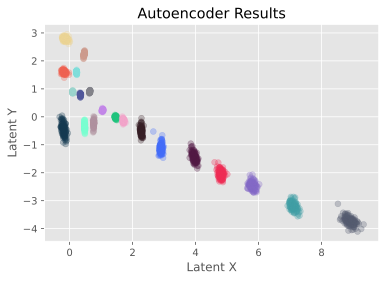

In [11]:
unique_labels = np.unique(y_test)

# loop over each cluster to plot the data
for index, unique_label in enumerate(unique_labels):
    latent_space = res_ae[y_test==unique_label]
    plt.scatter(latent_space[:,0], latent_space[:,1], alpha=0.3, c=cols[index])

plt.xlabel('Latent X')
plt.ylabel('Latent Y')
plt.title('Autoencoder Results')

Notice, in the above plot the cluster are much more independent and have less interference across the clusters. 

The autoencoder tended to find a better representation in 2-D space.



Clustering algorithms basically test how well-suited a point is to the cluster it's been assigned to versus a neighboring cluster point / cluster.

This is quantified by 'the silhouette score.'

Silhouette scores are on a range [-1, +1].
-1 --> poorly allocated to the cluster
+1 --> perfectly allocated to the cluster
The closer the silhouette score is to +1, the better the clustering.


In [12]:
silhouette_score(X_train, y_train)

0.6109772034818249

In [22]:
# Baseline "clustering score" using 50-dimensional data
silhouette_score(X_test, y_test)

0.6100948647899368

In [13]:
# PCA "clustering score"
silhouette_score(res_pca, y_test)

0.3678626934415406

In [14]:
# autoencoder "clustering score"
silhouette_score(res_ae, y_test)

0.8074659602068088

In terms of the **clustering** (how well a point belongs to its cluster), the autoencoder gives a better representation of the clusters than the original data.